<a href="https://colab.research.google.com/github/ajayhukam/Policy-Optimization/blob/main/PolicyOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Requirements**

In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gym

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, classification_report, roc_curve, auc

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from d3rlpy.algos import CQL
from d3rlpy.datasets import MDPDataset

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


**Load dataset (focused columns) & initial filtering — Task 1**

In [ ]:
DATA_PATH = "/content/accepted_2007_to_2018Q4.csv"
SAMPLE_FRAC = 0.25
USECOLS = [
    'loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'revol_util',
    'total_acc', 'open_acc', 'pub_rec', 'loan_status'
]

print("Reading CSV")
df = pd.read_csv(DATA_PATH, usecols=USECOLS, low_memory=False)
print("Original rows:", len(df))
if SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=SEED).reset_index(drop=True)
    print("After sampling rows:", len(df))

good_status = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(good_status)].copy()
print("After status filtering (Fully Paid / Charged Off):", len(df))

display(df.head())
display(df['loan_status'].value_counts())


Reading CSV
Original rows: 2260701
After sampling rows: 565175
After status filtering (Fully Paid / Charged Off): 335864


,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,open_acc,pub_rec,revol_util,total_acc
1,9600.0,36 months,12.99,C,C1,NaN,RENT,21900.0,Verified,Fully Paid,debt_consolidation,FL,10.03,0.0,13.0,1.0,38.9,20.0
2,4000.0,36 months,6.68,A,A3,4 years,MORTGAGE,83000.0,Not Verified,Fully Paid,major_purchase,FL,19.53,0.0,16.0,0.0,17.2,25.0
3,6025.0,36 months,10.91,B,B4,10+ years,RENT,52000.0,Not Verified,Fully Paid,debt_consolidation,MA,9.16,1.0,11.0,0.0,12.8,25.0
5,20000.0,36 months,9.49,B,B2,10+ years,MORTGAGE,100000.0,Not Verified,Fully Paid,debt_consolidation,NV,16.43,1.0,15.0,0.0,56.3,32.0
6,1000.0,36 months,8.18,B,B1,NaN,RENT,23000.0,Verified,Fully Paid,debt_consolidation,OH,16.34,1.0,6.0,0.0,77.1,38.0


,count
loan_status,
Fully Paid,268406
Charged Off,67458


**Target creation & simple EDA**

                        count unique                 top    freq  \
loan_amnt            335864.0    NaN                 NaN     NaN   
term                   335864      2           36 months  254830   
int_rate             335864.0    NaN                 NaN     NaN   
grade                  335864      7                   B   98273   
sub_grade              335864     35                  C1   21426   
emp_length             316382     11           10+ years  110301   
home_ownership         335864      6            MORTGAGE  166214   
annual_inc           335864.0    NaN                 NaN     NaN   
verification_status    335864      3     Source Verified  130168   
loan_status            335864      2          Fully Paid  268406   
purpose                335864     14  debt_consolidation  195383   
addr_state             335864     51                  CA   49002   
dti                  335766.0    NaN                 NaN     NaN   
delinq_2yrs          335864.0    NaN            

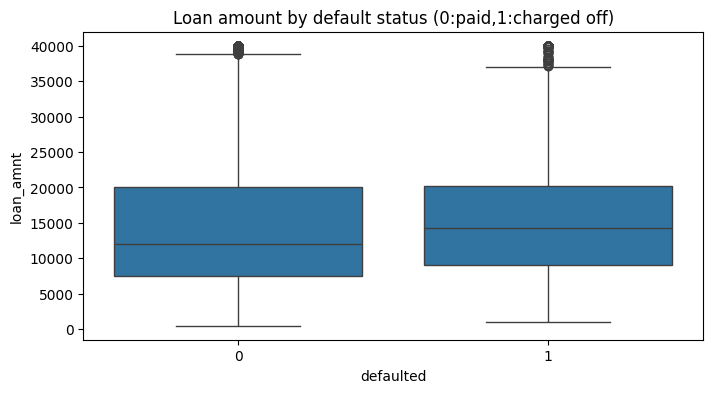

Overall default rate: 0.2008491532286878


In [ ]:
df['defaulted'] = (df['loan_status'] == 'Charged Off').astype(int)

print(df.describe(include='all').T)

missing = df.isna().mean().sort_values(ascending=False)
print("Missing fraction per column:\n", missing)

plt.figure(figsize=(8,4))
sns.boxplot(x='defaulted', y='loan_amnt', data=df)
plt.title("Loan amount by default status (0:paid,1:charged off)")
plt.show()

print("Overall default rate:", df['defaulted'].mean())

**Feature cleaning helpers**

In [ ]:
def parse_term(x):
    if pd.isna(x): return np.nan
    return int(x.split()[0])

def parse_percent_str(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and '%' in x:
        return float(x.strip().replace('%',''))/100.0
    try:
        return float(x)
    except:
        return np.nan

import re
def parse_emp_length(x):
    if pd.isna(x): return np.nan
    if x.strip() == 'n/a':
        return np.nan
    if '10+' in x:
        return 10
    if '< 1' in x:
        return 0
    m = re.search(r'(\d+)', x)
    return int(m.group(1)) if m else np.nan

df['term'] = df['term'].apply(parse_term)
df['int_rate'] = df['int_rate'].apply(parse_percent_str)
df['revol_util'] = df['revol_util'].apply(parse_percent_str)
df['emp_length'] = df['emp_length'].apply(parse_emp_length)


**Feature selection & preprocessing pipeline**

In [ ]:
NUMERIC_COLS = ['loan_amnt','int_rate','annual_inc','dti','revol_util',
                'total_acc','open_acc','pub_rec','delinq_2yrs','emp_length']
CAT_COLS = ['term','grade','sub_grade','home_ownership','verification_status','purpose','addr_state']

for c in NUMERIC_COLS + CAT_COLS:
    if c not in df.columns:
        print("Warning: column missing:", c)

X_df = df[NUMERIC_COLS + CAT_COLS].copy()
y = df['defaulted'].values
loan_amnt = df['loan_amnt'].values
int_rate_decimal = df['int_rate'].values

numeric_transformer = Pipeline = None
from sklearn.pipeline import Pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, NUMERIC_COLS),
    ('cat', categorical_transformer, CAT_COLS)
], remainder='drop')

X_train_df, X_test_df, y_train, y_test, loanamnt_train, loanamnt_test, int_rate_train, int_rate_test = \
    train_test_split(X_df, y, loan_amnt, int_rate_decimal, test_size=0.20, stratify=y, random_state=SEED)

X_train_df, X_val_df, y_train, y_val, loanamnt_train, loanamnt_val, int_rate_train, int_rate_val = \
    train_test_split(X_train_df, y_train, loanamnt_train, int_rate_train, test_size=0.2, stratify=y_train, random_state=SEED)

print("Train / Val / Test sizes:", len(X_train_df), len(X_val_df), len(X_test_df))

preprocessor.fit(X_train_df)

X_train = preprocessor.transform(X_train_df)
X_val = preprocessor.transform(X_val_df)
X_test = preprocessor.transform(X_test_df)

print("Feature matrix shape (train):", X_train.shape)

Train / Val / Test sizes: 214952 53739 67173
Feature matrix shape (train): (214952, 128)


**Supervised deep learning model (MLP) — training & evaluation**

In [ ]:
def make_loader(X, y, batch_size=256, shuffle=True):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y.reshape(-1,1), dtype=torch.float32)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, batch_size=512, shuffle=True)
val_loader = make_loader(X_val, y_val, batch_size=1024, shuffle=False)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128,64,32], dropout=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

input_dim = X_train.shape[1]
model = MLPClassifier(input_dim, hidden_dims=[256,128,64], dropout=0.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Using device:", device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

EPOCHS = 20
best_val_auc = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb.squeeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    all_logits = []
    all_y = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb)
            all_logits.append(logits.cpu().numpy())
            all_y.append(yb.numpy())
    all_logits = np.concatenate(all_logits)
    all_y = np.concatenate(all_y).reshape(-1)
    probs = 1.0 / (1.0 + np.exp(-all_logits))
    val_auc = roc_auc_score(all_y, probs)
    # F1 at 0.5 threshold
    preds = (probs >= 0.5).astype(int)
    val_f1 = f1_score(all_y, preds)

    print(f"Epoch {epoch}/{EPOCHS}: train_loss={avg_train_loss:.4f}, val_auc={val_auc:.4f}, val_f1={val_f1:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_mlp.pt")


Using device: cpu
Epoch 1/20: train_loss=0.4657, val_auc=0.7104, val_f1=0.1211
Epoch 2/20: train_loss=0.4564, val_auc=0.7130, val_f1=0.1258
Epoch 3/20: train_loss=0.4547, val_auc=0.7137, val_f1=0.1641
Epoch 4/20: train_loss=0.4534, val_auc=0.7135, val_f1=0.1120
Epoch 5/20: train_loss=0.4523, val_auc=0.7135, val_f1=0.1669
Epoch 6/20: train_loss=0.4513, val_auc=0.7142, val_f1=0.1593
Epoch 7/20: train_loss=0.4502, val_auc=0.7123, val_f1=0.1814
Epoch 8/20: train_loss=0.4491, val_auc=0.7124, val_f1=0.1326
Epoch 9/20: train_loss=0.4481, val_auc=0.7134, val_f1=0.1369
Epoch 10/20: train_loss=0.4467, val_auc=0.7113, val_f1=0.1829
Epoch 11/20: train_loss=0.4460, val_auc=0.7107, val_f1=0.1409
Epoch 12/20: train_loss=0.4447, val_auc=0.7090, val_f1=0.1693
Epoch 13/20: train_loss=0.4436, val_auc=0.7069, val_f1=0.1883
Epoch 14/20: train_loss=0.4422, val_auc=0.7080, val_f1=0.1913
Epoch 15/20: train_loss=0.4410, val_auc=0.7056, val_f1=0.1515
Epoch 16/20: train_loss=0.4399, val_auc=0.7061, val_f1=0.1606

In [ ]:
model.load_state_dict(torch.load("best_mlp.pt"))
model.eval()

test_loader = make_loader(X_test, y_test, batch_size=2048, shuffle=False)
all_logits = []
all_y = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        all_logits.append(logits.cpu().numpy())
        all_y.append(yb.numpy())
all_logits = np.concatenate(all_logits)
all_y = np.concatenate(all_y).reshape(-1)
probs_test = 1.0 / (1.0 + np.exp(-all_logits))
preds_test = (probs_test >= 0.5).astype(int)

test_auc = roc_auc_score(all_y, probs_test)
test_f1 = f1_score(all_y, preds_test)
print("Supervised MLP Test AUC:", test_auc)
print("Supervised MLP Test F1 (0.5 threshold):", test_f1)
print(classification_report(all_y, preds_test, digits=4, zero_division=1))


Supervised MLP Test AUC: 0.711292052363245
Supervised MLP Test F1 (0.5 threshold): 0.15720247881623878
              precision    recall  f1-score   support

         0.0     0.8111    0.9799    0.8876     53681
         1.0     0.5353    0.0921    0.1572     13492

    accuracy                         0.8016     67173
   macro avg     0.6732    0.5360    0.5224     67173
weighted avg     0.7557    0.8016    0.7409     67173



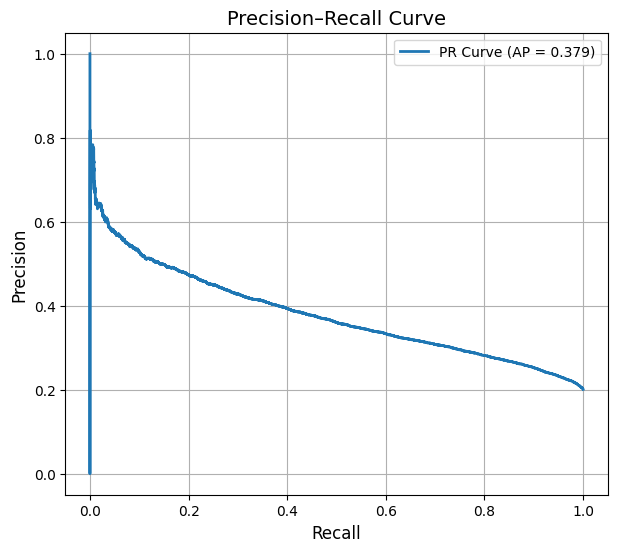

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(all_y, probs_test)
ap_score = average_precision_score(all_y, probs_test)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.3f})', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision–Recall Curve', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


**Task 3: Offline RL agent (state/action/reward) + training (CQL)**

In [ ]:
def compute_rewards(loan_amounts, int_rates, defaults):
    rewards = np.where(defaults == 0, loan_amounts * int_rates, -loan_amounts)
    return rewards.astype(np.float32)

rewards_train = compute_rewards(loanamnt_train, int_rate_train, y_train)
rewards_val = compute_rewards(loanamnt_val, int_rate_val, y_val)
rewards_test = compute_rewards(loanamnt_test, int_rate_test, y_test)

print("Example rewards (train):", rewards_train[:6])


Example rewards (train): [137550.  -9700.  -6000. -10000. 679700. -14400.]


**Create MDP Dataset for d3rlpy**

In [ ]:
def make_offline_dataset(X_array, rewards_array):
    n = X_array.shape[0]

    obs_approve = X_array.astype(np.float32)
    acts_approve = np.ones((n,), dtype=np.int32)
    rewards_approve = rewards_array.astype(np.float32)
    terms_approve = np.ones((n,), dtype=bool)

    obs_deny = X_array.astype(np.float32)
    acts_deny = np.zeros((n,), dtype=np.int32)
    rewards_deny = np.zeros((n,), dtype=np.float32)
    terms_deny = np.ones((n,), dtype=bool)

    obs = np.vstack([obs_approve, obs_deny])
    acts = np.concatenate([acts_approve, acts_deny])
    rewards = np.concatenate([rewards_approve, rewards_deny])
    terms = np.concatenate([terms_approve, terms_deny])
    return obs, acts, rewards, terms

obs_train, acts_train, rew_train, terms_train = make_offline_dataset(X_train, rewards_train)
obs_val, acts_val, rew_val, terms_val = make_offline_dataset(X_val, rewards_val)
obs_test, acts_test, rew_test, terms_test = make_offline_dataset(X_test, rewards_test)

print("Offline dataset sizes (train obs):", obs_train.shape, acts_train.shape, rew_train.shape)


Offline dataset sizes (train obs): (429904, 128) (429904,) (429904,)


In [ ]:
obs_rl = np.vstack([obs_train, obs_val])
acts_rl = np.concatenate([acts_train, acts_val])
rews_rl = np.concatenate([rew_train, rew_val])
terms_rl = np.concatenate([terms_train, terms_val])

mdp_dataset = MDPDataset(observations=obs_rl, actions=acts_rl, rewards=rews_rl, terminals=terms_rl)
print("MDPDataset created. Num transitions:", len(obs_rl))


2025-10-29 18:51.29 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(128,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-10-29 18:51.29 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-10-29 18:51.31 [info     ] Action size has been automatically determined. action_size=2
MDPDataset created. Num transitions: 537382


**Train a CQL (Conservative Q Learning) agent**

In [ ]:
from d3rlpy.algos import DiscreteCQLConfig
from d3rlpy.models.encoders import VectorEncoderFactory
import torch

cql_config = DiscreteCQLConfig(
    learning_rate=1e-3,
    batch_size=256,
    encoder_factory=VectorEncoderFactory(hidden_units=[256, 256]),
)

device = "cuda" if torch.cuda.is_available() else "cpu"
cql = cql_config.create(device=device)

cql.fit(
    mdp_dataset,
    n_steps=100000,
)

cql.save_model("discrete_cql_model")


2025-10-29 19:02.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(128,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-10-29 19:02.16 [debug    ] Building models...            
2025-10-29 19:02.16 [debug    ] Models have been built.       
2025-10-29 19:02.16 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20251029190216
2025-10-29 19:02.16 [info     ] Parameters                     params={'observation_shape': [128], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'learning_rate': 0.001, 'optim_factory': {'type': 'ada

Epoch 1/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-29 19:06.02 [info     ] DiscreteCQL_20251029190216: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00741239960193634, 'time_algorithm_update': 0.014760016703605652, 'loss': 74550.16286132812, 'td_loss': 74549.1258671875, 'conservative_loss': 1.0370001349031925, 'time_step': 0.022422052240371703} step=10000
2025-10-29 19:06.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029190216/model_10000.d3


Epoch 2/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-29 19:09.47 [info     ] DiscreteCQL_20251029190216: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.007282411050796508, 'time_algorithm_update': 0.014745491766929627, 'loss': 74490.84254101562, 'td_loss': 74489.78964101562, 'conservative_loss': 1.0528847286462784, 'time_step': 0.022270244216918946} step=20000
2025-10-29 19:09.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029190216/model_20000.d3


Epoch 3/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-29 19:13.33 [info     ] DiscreteCQL_20251029190216: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.00735130078792572, 'time_algorithm_update': 0.014894921851158142, 'loss': 74404.51785820312, 'td_loss': 74403.45626015625, 'conservative_loss': 1.0615778358697892, 'time_step': 0.02249327073097229} step=30000
2025-10-29 19:13.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029190216/model_30000.d3


Epoch 4/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-29 19:17.22 [info     ] DiscreteCQL_20251029190216: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.007420632863044739, 'time_algorithm_update': 0.015004541277885437, 'loss': 74605.09633203124, 'td_loss': 74604.00786210937, 'conservative_loss': 1.0885024738252163, 'time_step': 0.022673831605911254} step=40000
2025-10-29 19:17.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029190216/model_40000.d3


Epoch 5/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-29 19:21.09 [info     ] DiscreteCQL_20251029190216: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.007346622228622437, 'time_algorithm_update': 0.014887275576591492, 'loss': 74526.10854921876, 'td_loss': 74524.99971445312, 'conservative_loss': 1.1088205967247486, 'time_step': 0.022480768585205077} step=50000
2025-10-29 19:21.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029190216/model_50000.d3


Epoch 6/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-29 19:24.57 [info     ] DiscreteCQL_20251029190216: epoch=6 step=60000 epoch=6 metrics={'time_sample_batch': 0.00737632532119751, 'time_algorithm_update': 0.015051880860328675, 'loss': 74463.11967382813, 'td_loss': 74461.98330390625, 'conservative_loss': 1.1363817103981972, 'time_step': 0.022672821736335756} step=60000
2025-10-29 19:24.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029190216/model_60000.d3


Epoch 7/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-29 19:28.52 [info     ] DiscreteCQL_20251029190216: epoch=7 step=70000 epoch=7 metrics={'time_sample_batch': 0.007478149223327637, 'time_algorithm_update': 0.015575495600700378, 'loss': 74506.11370273438, 'td_loss': 74504.94339882812, 'conservative_loss': 1.1703280239522458, 'time_step': 0.023301856160163878} step=70000
2025-10-29 19:28.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029190216/model_70000.d3


Epoch 8/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-29 19:32.52 [info     ] DiscreteCQL_20251029190216: epoch=8 step=80000 epoch=8 metrics={'time_sample_batch': 0.007524912452697754, 'time_algorithm_update': 0.015993141055107116, 'loss': 74516.90321835938, 'td_loss': 74515.69553085938, 'conservative_loss': 1.2076994609475136, 'time_step': 0.023774658083915712} step=80000
2025-10-29 19:32.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029190216/model_80000.d3


Epoch 9/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-29 19:36.51 [info     ] DiscreteCQL_20251029190216: epoch=9 step=90000 epoch=9 metrics={'time_sample_batch': 0.007458175420761108, 'time_algorithm_update': 0.015912385249137878, 'loss': 74736.73590234375, 'td_loss': 74735.48904648438, 'conservative_loss': 1.2468564844250678, 'time_step': 0.023619004011154174} step=90000
2025-10-29 19:36.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029190216/model_90000.d3


Epoch 10/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-29 19:40.46 [info     ] DiscreteCQL_20251029190216: epoch=10 step=100000 epoch=10 metrics={'time_sample_batch': 0.007385627484321595, 'time_algorithm_update': 0.01566412651538849, 'loss': 74387.5985578125, 'td_loss': 74386.33250078125, 'conservative_loss': 1.266007926505804, 'time_step': 0.023298078560829164} step=100000
2025-10-29 19:40.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251029190216/model_100000.d3


**Task 4: Evaluation & Comparison**

In [ ]:
rl_actions = cql.predict(X_test.astype(np.float32))
rl_actions = np.array(rl_actions).astype(int)

est_rewards_rl = np.where(rl_actions == 1, rewards_test, 0.0)
estimated_value_rl = est_rewards_rl.mean()
print(f"RL policy estimated average reward per loan (test): {estimated_value_rl:.4f}")
print(f"Total expected profit on test (sum): {est_rewards_rl.sum():.2f} over {len(est_rewards_rl)} loans")


RL policy estimated average reward per loan (test): 124805.5781
Total expected profit on test (sum): 8383565312.00 over 67173 loans


In [ ]:
model.eval()
with torch.no_grad():
    val_logits = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy()
val_probs = 1.0/(1.0+np.exp(-val_logits))

thresholds = np.linspace(0.0, 1.0, 101)
best_tau = None
best_value = -1e12
for tau in thresholds:
    actions = (val_probs < tau).astype(int)
    est_rewards = np.where(actions == 1, rewards_val, 0.0)
    val = est_rewards.mean()
    if val > best_value:
        best_value = val
        best_tau = tau

print("Best validation threshold (max expected reward):", best_tau, "value:", best_value)

with torch.no_grad():
    test_logits = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()
test_probs = 1.0/(1.0+np.exp(-test_logits))
supervised_actions_test = (test_probs < best_tau).astype(int)
est_rewards_supervised = np.where(supervised_actions_test == 1, rewards_test, 0.0)
estimated_value_supervised = est_rewards_supervised.mean()
print("Supervised policy estimated avg reward (test):", estimated_value_supervised)
print("Supervised policy AUC (test):", test_auc, "F1 (0.5 threshold):", test_f1)


Best validation threshold (max expected reward): 0.71 value: 142075.8
Supervised policy estimated avg reward (test): 142327.45
Supervised policy AUC (test): 0.711292052363245 F1 (0.5 threshold): 0.15720247881623878


In [ ]:
always_approve_value = rewards_test.mean()
always_deny_value = 0.0
print("Always approve average reward:", always_approve_value)
print("Always deny average reward:", always_deny_value)

Always approve average reward: 142345.64
Always deny average reward: 0.0


**Examples where policies differ**

In [ ]:
test_df = X_test_df.reset_index(drop=True).copy()
inspection = test_df.copy()
inspection['y_true'] = y_test
inspection['loan_amnt'] = loanamnt_test
inspection['int_rate'] = int_rate_test
inspection['reward_if_approve'] = rewards_test
inspection['supervised_action'] = supervised_actions_test
inspection['rl_action'] = rl_actions
inspection['supervised_prob_default'] = test_probs

disagree = inspection[inspection['supervised_action'] != inspection['rl_action']]
print("Number of disagreements on test:", len(disagree))
display(disagree.head(8))


Number of disagreements on test: 6445


,loan_amnt,int_rate,annual_inc,dti,revol_util,total_acc,open_acc,pub_rec,delinq_2yrs,emp_length,...,sub_grade,home_ownership,verification_status,purpose,addr_state,y_true,reward_if_approve,supervised_action,rl_action,supervised_prob_default
2,20000.0,12.79,146000.0,20.40,70.1,25.0,14.0,3.0,0.0,10.0,...,C1,MORTGAGE,Not Verified,debt_consolidation,MD,0,255800.0,1,0,0.205658
8,12000.0,18.99,86000.0,30.74,65.6,46.0,24.0,0.0,1.0,2.0,...,D3,RENT,Source Verified,credit_card,PA,1,-12000.0,1,0,0.425703
26,15925.0,30.49,65000.0,22.19,83.8,16.0,7.0,0.0,0.0,3.0,...,F4,RENT,Source Verified,credit_card,CA,1,-15925.0,1,0,0.579072
30,13500.0,30.74,45000.0,16.88,16.9,11.0,9.0,0.0,0.0,2.0,...,F5,MORTGAGE,Source Verified,other,FL,0,414990.0,1,0,0.482622
38,24000.0,14.99,120000.0,5.09,59.6,37.0,14.0,1.0,1.0,7.0,...,C4,MORTGAGE,Verified,debt_consolidation,MD,0,359760.0,1,0,0.241028
42,16000.0,12.69,50000.0,34.14,61.4,13.0,7.0,0.0,0.0,5.0,...,C2,RENT,Verified,debt_consolidation,NJ,1,-16000.0,1,0,0.271237
59,16500.0,30.84,52000.0,31.16,14.4,23.0,14.0,1.0,0.0,7.0,...,G2,RENT,Source Verified,debt_consolidation,WA,1,-16500.0,1,0,0.655230
69,24000.0,22.39,73000.0,15.63,35.4,29.0,9.0,1.0,0.0,NaN,...,E1,MORTGAGE,Verified,debt_consolidation,IL,1,-24000.0,1,0,0.358776
